In [1]:
## general
import numpy as np
import datetime
import copy
import cf_units
import xarray as xr
import os
import sys
from tqdm import tqdm_notebook as tqdm
import datetime as dt
import matplotlib as mpl
import math
import pandas as pd

## statistics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal # to compute likelihood
from sklearn.impute import SimpleImputer
#from scipy.stats import shapiro  #check normalicy of seasonal trend distribution
from scipy.optimize import curve_fit, fmin, fminbound, minimize, rosen_der, least_squares
from sklearn.preprocessing import StandardScaler

## plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import mplotutils as mpu
import matplotlib.patches as mpatches

In [2]:
def norm_cos_wgt(lats):
    
    from numpy import cos, deg2rad
    
    return np.cos(np.deg2rad(lats))

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [3]:
def load_data_obs(obs, Tref_start='1951-01-01', Tref_end='1980-01-01', Tblendglob_idx=False):
    """ Load the observations.

    Keyword argument:
    - obs: currently implemented for "best" and "cowtan"
    - Tref_start: starting point for the reference period with default 1951 (ie BEST Tref)
    - Tref_end: last year still INCLUDED for the reference period with default 1980 (ie BEST Tref) (ATTENTION: different from load_data_single_mod where is the first NOT included)
    - Tblend_idx: whether to compute the blended Tanglob anomaly or not (default = False)

    Output:
    - y: the land grid points of the anomalies of the variable on grid centered over 0 longitude (like the srexgrid) 
    - time: the time slots
    - Tblendglob = area weighted global mean temperature (blend from SST over ocean and tas over land + sea ice)
        
            
    """
    dir_data = '/home/tristan/mesmer/data/'
    
    # read in the land-sea mask
    file_ls = 'interim_invariant_lsmask_regrid.nc' # ERA-interim mask regridded by Richard from 73x144 to 72x144
    frac_l = xr.open_mfdataset(dir_data+file_ls) #land-sea mask of ERA-interim bilinearily interpolated 
    frac_l = frac_l.where(frac_l.lat>-60,0) # remove Antarctica from frac_l field (ie set frac l to 0)
    idx_l=np.squeeze(frac_l.lsm.values)>0.0 # idex land #-> everything >0 I consider land

    lons, lats = np.meshgrid(frac_l.lon.values,frac_l.lat.values) # the lon, lat grid (just to derive weights)   
    wgt = norm_cos_wgt(lats) # area weights of each grid point
    
    
    if obs == 'best':
        obs_file='obs_data_25.nc' 
        ds_obs=xr.open_mfdataset(dir_data+obs_file).rename({'temperature':'tas'}).sel(time=slice('1880-01-01', '2022-01-01'))
        time = np.arange(np.datetime64('1880-01-01'), np.datetime64('2022-01-01'), dtype='datetime64[M]')
        ds_obs['time'] = time
        ds_obs['lon'] = ds_obs['lon']-180
        
    if obs == 'giss':
        file='GISS_tas_g25.nc' 
        ds_obs=xr.open_mfdataset(dir_data+file).rename({'tempanomaly':'tas'}).sel(time=slice('1880-01-01', '2022-01-01')).drop(['time_bnds'])
        time = np.arange(np.datetime64('1880-01-01'), np.datetime64('2022-01-01'), dtype='datetime64[M]')
        ds_obs['time'] = time
        ds_obs['lon'] = ds_obs['lon']-180
        
    T_ref = ds_obs.tas.sel(time=slice(Tref_start, Tref_end)).mean(dim='time')
    if Tblendglob_idx == True:
        tas=ds_obs.tas.values-T_ref.values
        Tblendglob=np.zeros(tas.shape[0])
        for t in np.arange(tas.shape[0]):
            idx_valid = ~np.isnan(tas[t])
            Tblendglob[t] = np.average(tas[t,idx_valid],weights=wgt[idx_valid]) #area weighted of available obs -> less data available at beginning        
    
    y=(ds_obs.tas.values-T_ref.values)[:,idx_l]
    time=ds_obs.time.values
    
    if Tblendglob_idx==True:
        return y,time,Tblendglob
    else:
        return y,time

In [15]:
def compute_wgt_reg_obs(reg):
    
    dir_data = "/home/tristan/mesmer/data/"
    file_ls = "interim_invariant_lsmask_regrid.nc"
    file_obs = "obs_data_25.nc"
    file_srex = "IPCC-WGII-continental-regions_srex_mask.nc"

    df_obs=xr.open_mfdataset(dir_data+file_obs)

    # SREX names ordered according to SREX mask
    srex_names = ['GIC','NWN','NEN','WNA','CNA','ENA','NCA','SCA','CAR','NWS','NSA','NES','SAM','SWS','SES','SSA','NEU',
             'WCE','EEU','MED','CAF','NEAF','SEAF','WSAF','ESAF','MDG', 'RAR', 'WSB', 'ESB', 'RFE', 'WCA', 'ECA', 'TIB',
                 'EAS', 'ARP', 'SAS', 'SEA', 'NAU', 'CAU', 'EAU', 'SAU', 'NZ', 'EAN', 'WAN'] 
        
    # srex_raw nrs from 1-26
    srex_raw = xr.open_mfdataset(dir_data+file_srex, combine='by_coords',decode_times=False) 
    lons, lats = np.meshgrid(srex_raw.lon.values,srex_raw.lat.values) #derive the lat, lon grid
    
    #apply land mask
    frac_l = xr.open_mfdataset(dir_data+file_ls, combine='by_coords',decode_times=False) #land-sea mask
    frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))
    frac_l = frac_l.where(frac_l.lat>-60,0)
    idx_l=np.squeeze(frac_l.lsm.values)>0.0 
    
    wgt = np.cos(np.deg2rad(lats)) # area weights of each grid point
    wgt_l = (wgt*frac_l_raw)[idx_l] # area weights for land grid points (including taking fraction land into consideration)
    lon_pc, lat_pc = mpu.infer_interval_breaks(frac_l.lon, frac_l.lat) # the lon / lat for the plotting with pcolormesh
    srex = (np.squeeze(srex_raw.srex_mask.values)-1)[idx_l] # srex indices on land

    
    if reg == 'Global_land':
        idx_reg_l=np.ones(3043,dtype=bool)
        idx_reg_l_grid = copy.deepcopy(idx_l)
        
    else:
        idx_reg = srex_names.index(reg) # index region
        idx_reg_l = (srex==idx_reg) #index land (l) gp inside specific srex region (reg)
        srex_grid=np.zeros(idx_l.shape)
        srex_grid[idx_l]=srex # ATTENTION: not 100% convinced yet if this is correct (I get some missing values that
        idx_reg_l_grid = (srex_grid==idx_reg)#& idx_l 
    
    datasets = ["best", "giss"]
    
    obs_tas_mean = {}
    x = {}
    list_x = {}
    y_mon = {}
    y_ann = {}
    
    for dataset in datasets:
        obs_tas_mean[dataset] = {}
        if dataset == "giss":
            for i in np.arange(len(time_obs)):
                idx_valid=~np.isnan(tas_GISS[i][idx_reg_l])
                obs_tas_mean[dataset][i] = np.average(tas_GISS[i][idx_reg_l][idx_valid],weights=wgt_l[idx_reg_l][idx_valid]) 
    
        if dataset == "best":
            for i in np.arange(len(time_obs)):
                idx_valid=~np.isnan(tas_BEST[i][idx_reg_l])
                obs_tas_mean[dataset][i] = np.average(tas_BEST[i][idx_reg_l][idx_valid],weights=wgt_l[idx_reg_l][idx_valid])
                
        x[dataset] = obs_tas_mean[dataset].items()
        list_x[dataset] = list(x[dataset])
        y_mon[dataset] = np.array(list_x[dataset])[:, -1]
        y_ann[dataset] = pd.DataFrame({"time":time_obs, "tas":y_mon[dataset]}).set_index("time")
        y_ann[dataset] = y_ann[dataset].resample("Y").mean()
        print(dataset, reg)
        
    time = np.arange(np.datetime64('1880-01-01'), np.datetime64('2022-01-01'), dtype='datetime64[Y]')
    return y_mon, y_ann, time

In [13]:
dir_data = "/home/tristan/mesmer/data/"
file_srex = "IPCC-WGII-continental-regions_srex_mask.nc"
srex_raw = xr.open_mfdataset(dir_data+file_srex, combine='by_coords',decode_times=False) 
srex_raw

<xarray.Dataset>
Dimensions:    (lat: 72, lon: 144)
Coordinates:
  * lat        (lat) float64 -89.75 -87.25 -84.75 -82.25 ... 82.75 85.25 87.75
  * lon        (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
Data variables:
    srex_mask  (lat, lon) float64 dask.array<chunksize=(72, 144), meta=np.ndarray>

In [14]:
dir_data = "/home/tristan/mesmer/data/"
file_ls = "interim_invariant_lsmask_regrid.nc"
file_obs = "obs_data_25.nc"
file_srex = "IPCC-WGII-continental-regions_srex_mask.nc"
file_srex_shape = "referenceRegions.shp"

df_obs=xr.open_mfdataset(dir_data+file_obs)

# SREX names ordered according to SREX mask
srex_names = ['GIC','NWN','NEN','WNA','CNA','ENA','NCA','SCA','CAR','NWS','NSA','NES','SAM','SWS','SES','SSA','NEU',
             'WCE','EEU','MED','CAF','NEAF','SEAF','WSAF','ESAF','MDG', 'RAR', 'WSB', 'ESB', 'RFE', 'WCA', 'ECA', 'TIB',
                 'EAS', 'ARP', 'SAS', 'SEA', 'NAU', 'CAU', 'EAU', 'SAU', 'NZ', 'EAN', 'WAN'] 

# srex_raw nrs from 1-26
srex = xr.open_mfdataset(dir_data+file_srex, combine='by_coords',decode_times=False) 
lons, lats = np.meshgrid(df_obs.lon.values,df_obs.lat.values) #derive the lat, lon grid

#apply land mask
frac_l = xr.open_mfdataset(dir_data+file_ls, combine='by_coords',decode_times=False) #land-sea mask
frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))
frac_l = frac_l.where(frac_l.lat>-60,0)
idx_l=np.squeeze(frac_l.lsm.values)>0.0 

# reg='ALA'
# idx_reg = srex_names.index(reg)+1 
# idx_reg_l = (srex.srex_mask.values[idx_l]==idx_reg)
# idx_reg_l_grid = (srex.srex_mask.values==idx_reg) & idx_l
 
wgt = np.cos(np.deg2rad(lats)) # area weights of each grid point
wgt_l = (wgt*frac_l_raw)[idx_l] # area weights for land grid points (including taking fraction land into consideration)
lon_pc, lat_pc = mpu.infer_interval_breaks(frac_l.lon, frac_l.lat) # the lon / lat for the plotting with pcolormesh

print(wgt.shape)

(72, 144)


In [24]:
#### load monthly tas for each grid point ########################################
datasets = ["best", "giss"]
reg = 'CNA'

tas_BEST, time_obs = load_data_obs("best")
tas_GISS, time_obs = load_data_obs("giss")


### compute weighted mean TAS across all land surface gridpoints ####################

obs_mon, obs_ann, time_obs_ann = compute_wgt_reg_obs(reg)

best CNA
giss CNA


In [25]:
obs_mon['giss']

array([-1.31986797, -0.76623542,  0.62940624, ...,  1.51785492,
        1.66165249,  2.74839323])

In [26]:
obs_giss_smt = moving_average(obs_mon['giss'], 60)
obs_best_smt = moving_average(obs_mon['best'], 60)

In [27]:
obs_giss_smt.shape

(1645,)

In [28]:
### set plot params

params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
          'figure.figsize': (9,5),
          "font.family": "serif",
         'ytick.labelsize':'large',
         "font.weight":"normal",
         "axes.labelweight":"normal"}
plt.rcParams.update(params)

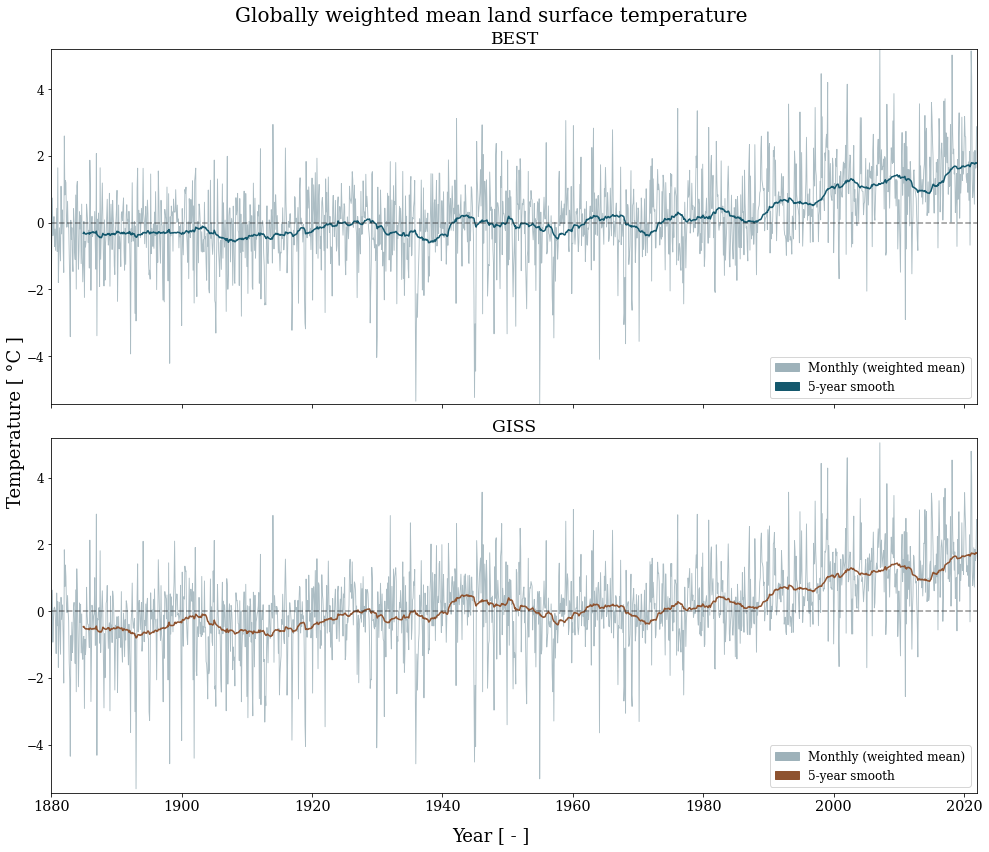

In [29]:
### start plotting

y_min = -1.5
y_max = 1.5

#first set times for x-axes
time = pd.date_range(start='1880-01-01', end='2021-12-31', freq='MS') 
time_smt = pd.date_range(start='1884-12-01', end='2021-12-31', freq='MS')

fig, (ax1,ax2) = plt.subplots(2, figsize=(14,12), sharex=True, sharey=True)
fig.suptitle("Globally weighted mean land surface temperature", fontsize=20)
fig.supylabel("Temperature [ °C ]", fontsize=18)
fig.supxlabel("Year [ - ]", fontsize=18)

#create legend
monthly_vals = mpatches.Patch(color="#9EB2BA", label="Monthly (weighted mean)")
obs_yr_vals = mpatches.Patch(color="#14586D", label="5-year smooth")
regrid_yr_vals = mpatches.Patch(color="#8E5330", label="5-year smooth")

ax1.plot(time,
       obs_mon['best'],
        color="#9EB2BA", lw=0.90, alpha=0.85)
ax1.plot(time_smt,
       obs_best_smt,
        color="#14586D")
ax1.set(title="BEST")
ax1.legend(handles=[monthly_vals, obs_yr_vals], loc="lower right", prop={'size': 12})
ax1.axhline(y=0, color='#2a2a2a', linestyle='--', alpha=0.5)
#plt.ylim(y_min, y_max)

ax2.plot(time,
       obs_mon['giss'],
        color="#9EB2BA",lw=0.90, alpha=0.85)
ax2.plot(time_smt,
       obs_giss_smt,
        color="#8E5330")
ax2.set(title="GISS")
ax2.legend(handles=[monthly_vals, regrid_yr_vals], loc="lower right", prop={'size': 12})
ax2.axhline(y=0, color='#2a2a2a', linestyle='--', alpha=0.5)

# annual_avg = mpatches.Patch(color=)

plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


In [5]:
dir_in_data = '/home/tristan/mesmer/data/'
file = 'GISS_tas_g25.nc'

df_GISS = xr.open_mfdataset(dir_in_data+file).roll(lon=72)

In [6]:
df_GISS['lon'] = df_GISS['lon'] - 180
df_GISS['temp'] = df_GISS['tempanomaly']
df_GISS = df_GISS.drop(['tempanomaly'])
df_GISS
#### create climatology array #################

<xarray.Dataset>
Dimensions:    (time: 1709, bnds: 2, lon: 144, lat: 72)
Coordinates:
  * time       (time) datetime64[ns] 1880-01-15 1880-02-15 ... 2022-05-15
  * lon        (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * lat        (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(1709, 2), meta=np.ndarray>
    temp       (time, lat, lon) float32 dask.array<chunksize=(1709, 72, 144), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Sun Jul 03 16:18:14 2022: cdo remapcon2,r144x72 GISS_tas.nc...
    source:       http://data.giss.nasa.gov/gistemp/
    institution:  NASA Goddard Institute for Space Studies
    title:        GISTEMP Surface Temperature Analysis
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

In [7]:
### calculate GISS climatology ###########s

clm = df_GISS.sel(time=slice('1951-01-01','1980-01-01')).groupby('time.month').mean(dim='time')
GISS_climatology = clm.temp.values
GISS_climatology.shape

(12, 72, 144)

<xarray.Dataset>
Dimensions:  (time: 1709, lon: 144, lat: 72)
Coordinates:
  * time     (time) float64 -2.839e+18 -2.836e+18 ... 1.65e+18 1.653e+18
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
Data variables:
    temp     (time, lat, lon) float32 dask.array<chunksize=(1709, 72, 144), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Sun Jul 03 16:18:14 2022: cdo remapcon2,r144x72 GISS_tas.nc...
    source:       http://data.giss.nasa.gov/gistemp/
    institution:  NASA Goddard Institute for Space Studies
    title:        GISTEMP Surface Temperature Analysis
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

In [11]:
# load the land mask as frac_l
dir_in_geo_dist = '/home/tristan/mesmer/data/'
frac_l = xr.open_mfdataset(dir_in_geo_dist + 'interim_invariant_lsmask_regrid.nc', combine='by_coords',decode_times=False)

frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))  #land-sea mask of ERA-interim bilinearily interpolated 

frac_l = frac_l.where(frac_l.lat>-60,0)  # remove Antarctica from frac_l field (ie set frac l to 0)

idx_l=np.squeeze(frac_l.lsm.values)>0.0 # idx_l = index land -> idex land #-> everything >0 we consider as land

lon_pc, lat_pc = mpu.infer_interval_breaks(frac_l.lon, frac_l.lat)  ## is this needed??

## Load in GISS dataset and use climatology values from BEST?

In [12]:
dir_in_data_mod = '/home/tristan/mesmer/data/'

# prepare the inputs as array
BEST_data = 'obs_data_25.nc'
data_mask = 'interim_invariant_lsmask_regrid.nc'       

df_BEST = xr.open_mfdataset(dir_in_data_mod+BEST_data).roll(lon=72) #open observation data

#create the climatology values array
nr_years = 112
tot_months = 12*nr_years 

#create the climatology values array
y_ma = np.zeros((tot_months,idx_l.sum()))  #create emtpy array with correct shape
for i in range(tot_months):
    y_ma[i] = GISS_climatology[i%12,idx_l]    #fill climatology values in the array

#create test data over date range - here, 112 years so 1910 incl. to 2022. 
## 1344 is the number of months from 1910 until 2022
data_test = np.nan_to_num(np.array([df_GISS.temp.values[360:1704,idx_l]]))
data_test = data_test.reshape(tot_months,idx_l.sum())

print(data_test.shape)

###load in monthly temperature values by adding the temp anomolies to the climatology
y_all_mon = np.add(y_ma, data_test)     

# now subtract the yearly average climatology so we are left with residuals
y_all_mon = y_all_mon - np.reshape(np.tile(np.mean(df_BEST.climatology.values[:,idx_l],axis=0),tot_months),(tot_months,idx_l.sum()))   

# ################## UNTIL HERE #########################             

#calculate annual average temperature values- here we use nanmean to calculate the annual means for each gridpoint but skipping any Nan values
y_all = np.mean(y_all_mon.reshape(-1,12,idx_l.sum()),axis=1)
print(y_all.shape)

(1344, 3043)
(112, 3043)


## start plotting the data

In [13]:
### set plot params

params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
          'figure.figsize': (9,5),
          "font.family": "serif",
         'ytick.labelsize':'x-large',
         "font.weight":"normal",
         "axes.labelweight":"normal"}
plt.rcParams.update(params)

In [ ]:
######## convert datetime64 to float for averaging #########

df_GISS['time'] = df_GISS['time'].values.astype(float)
df_GISS = df_GISS.drop(['time_bnds'])
df_GISS

In [113]:
def cos_wgt(ds, lat_string):
    
    from numpy import cos, deg2rad
    if lat_string == 'latitude':
        weights = np.cos(np.deg2rad(ds.latitude))
        
    else:
        weights = np.cos(np.deg2rad(ds.lat))
    
    return weights

wgt = cos_wgt(df_GISS, 'lat')
wgt

<xarray.DataArray 'lat' (lat: 72)>
array([0.02181489, 0.06540313, 0.10886687, 0.15212339, 0.19509032,
       0.23768589, 0.27982901, 0.32143947, 0.36243804, 0.40274669,
       0.44228869, 0.48098877, 0.51877326, 0.55557023, 0.59130965,
       0.62592347, 0.65934582, 0.69151306, 0.72236396, 0.75183981,
       0.77988448, 0.8064446 , 0.83146961, 0.85491187, 0.87672676,
       0.89687274, 0.91531148, 0.93200787, 0.94693013, 0.96004985,
       0.97134207, 0.98078528, 0.98836151, 0.99405634, 0.99785892,
       0.99976203, 0.99976203, 0.99785892, 0.99405634, 0.98836151,
       0.98078528, 0.97134207, 0.96004985, 0.94693013, 0.93200787,
       0.91531148, 0.89687274, 0.87672676, 0.85491187, 0.83146961,
       0.8064446 , 0.77988448, 0.75183981, 0.72236396, 0.69151306,
       0.65934582, 0.62592347, 0.59130965, 0.55557023, 0.51877326,
       0.48098877, 0.44228869, 0.40274669, 0.36243804, 0.32143947,
       0.27982901, 0.23768589, 0.19509032, 0.15212339, 0.10886687,
       0.06540313, 0.02181489])
Coordinates:
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y

In [169]:
df_weighted = df_GISS.weighted(wgt)
df_weighted_mean = df_weighted.mean(("lat", "lon"))
df_weighted_mean

AttributeError: 'Dataset' object has no attribute 'shape'

In [126]:
df_obs_np = np.array(df_weighted_mean['temp'])

print(df_obs_np.shape)

df_obs_smooth = df_weighted_mean.rolling(time=12*5, center=True).mean()
df_obs_smooth = np.array(df_obs_smooth['temp'])

print(df_obs_smooth.shape)

(1709,)
(1709,)


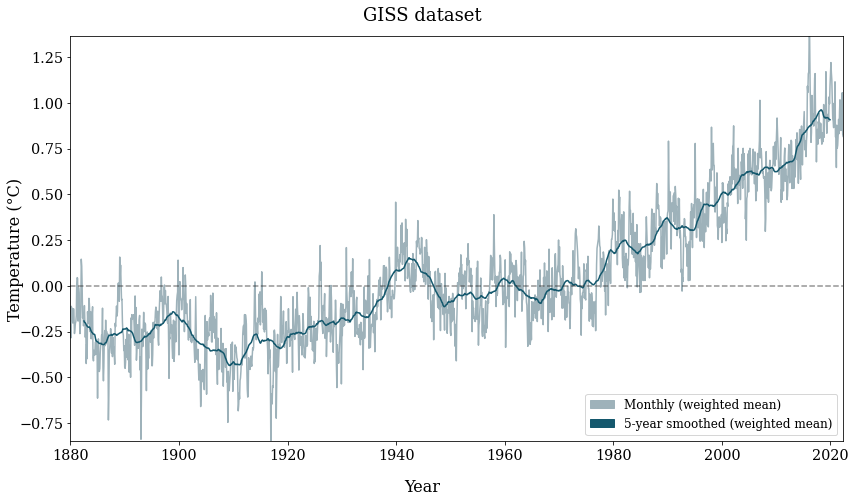

In [132]:
time = np.arange(np.datetime64('1880-01-01'), np.datetime64('2022-06-01'), dtype='datetime64[M]')
time2 = np.arange(np.datetime64('1880'), np.datetime64('2022'), dtype='datetime64[Y]')

fig, ax = plt.subplots(figsize=(12,7))
fig.suptitle("GISS dataset", fontsize=18)
fig.supylabel("Temperature (°C)", fontsize=16)
fig.supxlabel("Year", fontsize=16)

#create legend
monthly_vals = mpatches.Patch(color="#9EB2BA", label="Monthly (weighted mean)")
obs_yr_vals = mpatches.Patch(color="#14586D", label="5-year smoothed (weighted mean)")


ax.plot(time,
       df_obs_np,
        color="#9EB2BA")
ax.plot(time,
       df_obs_smooth,
        color="#14586D")

plt.axhline(y=0, color='#2a2a2a', linestyle='--', alpha=0.5)

ax.legend(handles=[monthly_vals, obs_yr_vals], loc="lower right", prop={'size': 12})


plt.tight_layout()
plt.margins(x=0, y=0)
plt.show()

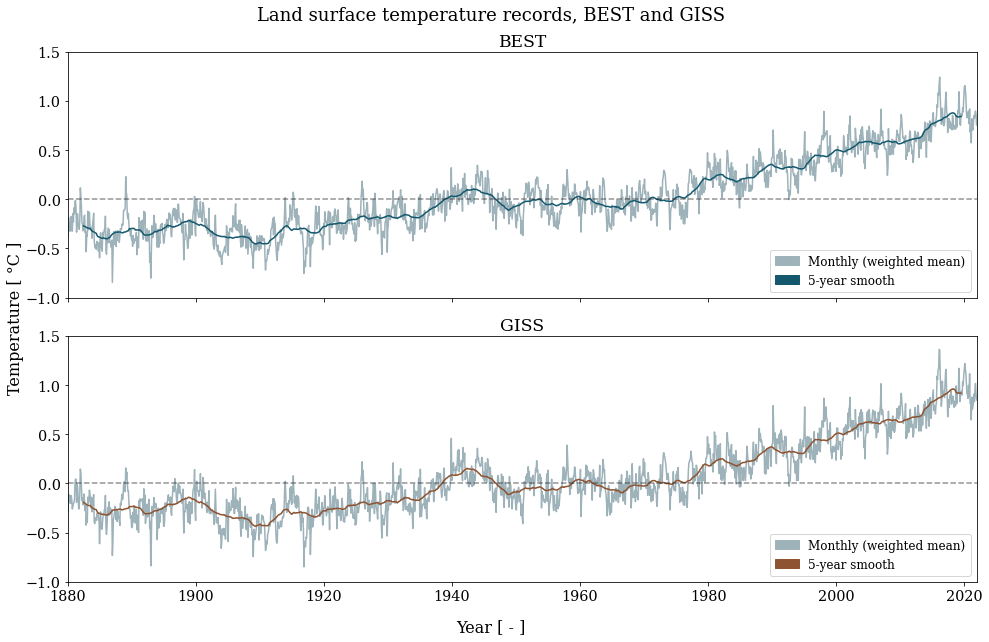

In [168]:
dir_in_data_mod = '/home/tristan/mesmer/data/'
    
#prepare the inputs as array
BEST_data = 'obs_data_25.nc'
GISS_data = 'GISS_tas_g25.nc'

# load in full Earth observation data
df_BEST = xr.open_mfdataset(dir_in_data_mod+BEST_data).roll(lat=72).sel(time=slice('1880-01-01','2022-01-01'))
df_GISS = xr.open_mfdataset(dir_in_data_mod+GISS_data).roll(lat=72).sel(time=slice('1880-01-01','2022-01-01'))

wgt_BEST = cos_wgt(df_BEST, 'lat')
wgt_GISS = cos_wgt(df_GISS, 'lat')

df_BEST_weighted = df_BEST.weighted(wgt_BEST)

df_GISS['temp'] = df_GISS['tempanomaly']
df_GISS = df_GISS.drop(['tempanomaly'])
df_GISS['time'] = df_GISS['time'].values.astype(float)
df_GISS = df_GISS.drop(['time_bnds'])
df_GISS_weighted = df_GISS.weighted(wgt_GISS)

df_BEST_weighted_mean = df_BEST_weighted.mean(("lat", "lon"))
df_GISS_weighted_mean = df_GISS_weighted.mean(("lat", "lon"))

df_BEST_smooth = df_BEST_weighted_mean.rolling(time=12*5, center=True).mean()
df_GISS_smooth = df_GISS_weighted_mean.rolling(time=12*5, center=True).mean()

df_BEST_np = np.array(df_BEST_weighted_mean['temperature'])
df_GISS_np = np.array(df_GISS_weighted_mean['temp'])

df_BEST_smooth_np = np.array(df_BEST_smooth['temperature'])
df_GISS_smooth_np = np.array(df_GISS_smooth['temp'])

### start plotting

y_min = -1.0
y_max = 1.5

#first set times for x-axes
time = np.arange(np.datetime64('1880-01-01'), np.datetime64('2022-01-01'), dtype='datetime64[M]')

fig, (ax1,ax2) = plt.subplots(2, figsize=(14,9), sharex=True, sharey=True)
fig.suptitle("Land surface temperature records, BEST and GISS", fontsize=18)
fig.supylabel("Temperature [ °C ]", fontsize=16)
fig.supxlabel("Year [ - ]", fontsize=16)

#create legend
monthly_vals = mpatches.Patch(color="#9EB2BA", label="Monthly (weighted mean)")
obs_yr_vals = mpatches.Patch(color="#14586D", label="5-year smooth")
regrid_yr_vals = mpatches.Patch(color="#8E5330", label="5-year smooth")

ax1.plot(time,
       df_BEST_np,
        color="#9EB2BA")
ax1.plot(time,
       df_BEST_smooth_np,
        color="#14586D")
ax1.set(title="BEST")
ax1.legend(handles=[monthly_vals, obs_yr_vals], loc="lower right", prop={'size': 12})
ax1.axhline(y=0, color='#2a2a2a', linestyle='--', alpha=0.5)
plt.ylim(y_min, y_max)

ax2.plot(time,
       df_GISS_np,
        color="#9EB2BA")
ax2.plot(time,
       df_GISS_smooth_np,
        color="#8E5330")
ax2.set(title="GISS")
ax2.legend(handles=[monthly_vals, regrid_yr_vals], loc="lower right", prop={'size': 12})
ax2.axhline(y=0, color='#2a2a2a', linestyle='--', alpha=0.5)

# annual_avg = mpatches.Patch(color=)

plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
